<a href="https://colab.research.google.com/github/Gongsoo/Python3/blob/main/pytorch_Fashion_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download=True,
    transform = ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0,torch.tensor(y),value=1))
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download=True,
    transform = ToTensor()
)

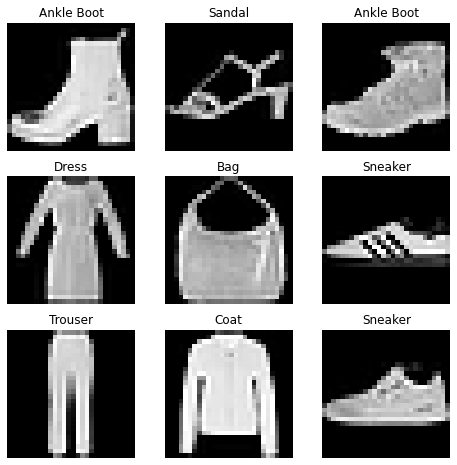

In [11]:
labels_map = {
    0:'T-Shirt',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle Boot',
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1,cols*rows +1) :
  sample_idx = torch.randint(len(training_data), size = (1,)).item()
  img, label= training_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(),cmap="gray")
plt.show()

In [13]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [40]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device =  "cpu"
print(f"Using {device} device")

Using cpu device


In [38]:
class NeuralNetwork(nn.Module) :
  def __init__(self) :
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(28*28,512),
        nn.ReLU(),
        nn.Linear(512,512),
        nn.ReLU(),
        nn.Linear(512,10),
    )
  def forward(self, x) :
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

In [41]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [42]:
X = torch.rand(1, 28, 28)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([8])


In [48]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

learning_rate = 1e-3
batch_size = 64
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # 예측(prediction)과 손실(loss) 계산
        pred = model(X)
        loss = loss_fn(pred, y)

        # 역전파
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296139  [    0/60000]
loss: 0.556885  [ 6400/60000]
loss: 0.388063  [12800/60000]
loss: 0.499986  [19200/60000]
loss: 0.433638  [25600/60000]
loss: 0.419906  [32000/60000]
loss: 0.360760  [38400/60000]
loss: 0.515290  [44800/60000]
loss: 0.481023  [51200/60000]
loss: 0.500064  [57600/60000]
Test Error: 
 Accuracy: 84.5%, Avg loss: 0.422807 

Epoch 2
-------------------------------
loss: 0.280841  [    0/60000]
loss: 0.363613  [ 6400/60000]
loss: 0.293424  [12800/60000]
loss: 0.412354  [19200/60000]
loss: 0.423361  [25600/60000]
loss: 0.388932  [32000/60000]
loss: 0.313770  [38400/60000]
loss: 0.453531  [44800/60000]
loss: 0.392982  [51200/60000]
loss: 0.472265  [57600/60000]
Test Error: 
 Accuracy: 85.0%, Avg loss: 0.398086 

Epoch 3
-------------------------------
loss: 0.230252  [    0/60000]
loss: 0.345882  [ 6400/60000]
loss: 0.235083  [12800/60000]
loss: 0.302539  [19200/60000]
loss: 0.363283  [25600/60000]
loss: 0.338294  [32000/600